In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

# Task 1
Train and fine-tune a Decision Tree for the moons dataset by following these steps:

a. Use make_moons(n_samples=10000, noise=0.4) to generate a moons dataset.

b. Use train_test_split() to split the dataset into a training set and a test set.

c. Use grid search with cross-validation (with the help of the GridSearchCV class) to find good hyperparameter values for a DecisionTreeClassifier. Hint: try various values for max_leaf_nodes.

d. Train it on the full training set using these hyperparameters, and measure your model’s performance on the test set. You should get roughly 85% to 87% accuracy.


In [2]:
# import data, libraries, metrics from sklearn
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score


In [3]:
# prepare data

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

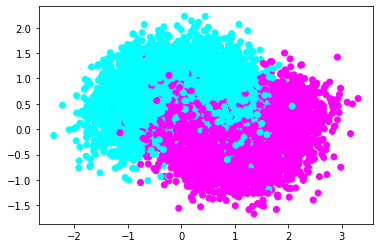

In [4]:
plt.scatter(X[:,0],X[:,1],c=y,cmap="cool")

In [5]:
# split data into the train and test parts

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
# tune hyperparameters with GridSearchCV

dt_clf = DecisionTreeClassifier( )
criterion = ['gini', 'entropy']
max_leaf_nodes = [10, 20, 30, 50, 100]
max_depth = [5, 10, 15, 20, 50, 100]
max_features = [None, 'sqrt', 'log2']

hyperparams = {
    'criterion': criterion,
    'max_leaf_nodes': max_leaf_nodes,
    'max_depth': max_depth,
    'max_features': max_features
}

g_search = GridSearchCV(dt_clf, hyperparams, cv=10, scoring='accuracy')
g_search.fit(X, y)
print("Best params: ", g_search.best_params_)
print("Best score: ", g_search.best_score_)

Best params:  {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': 30}
Best score:  0.8614


In [7]:
# fit model with tuned parameters

df_clf = DecisionTreeClassifier(criterion='gini', max_depth=10, max_features=None, max_leaf_nodes=30)
df_clf.fit(X_train, y_train)
dt_pred = df_clf.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_pred)
print('Accuracy score: ', dt_accuracy)

Accuracy score:  0.8636


# Task 2
Grow a forest by following these steps:

a. Continuing the previous exercise, generate 1,000 subsets of the training set, each containing 100 instances selected randomly. Hint: you can use Scikit-Learn’s ShuffleSplit class for this.

b. Train one Decision Tree on each subset, using the best hyperparameter values found in the previous exercise. Evaluate these 1,000 Decision Trees on the test set. Since they were trained on smaller sets, these Decision Trees will likely perform worse than the first Decision Tree, achieving only about 80% accuracy.

c. Now comes the magic. For each test set instance, generate the predictions of the 1,000 Decision Trees, and keep only the most frequent prediction (you can use SciPy’s mode() function for this). This approach gives you majority-vote predictions over the test set.

d. Evaluate these predictions on the test set: you should obtain a slightly higher accuracy than your first model (about 0.5 to 1.5% higher). Congratulations, you have trained a Random Forest classifier!



In [23]:
# split subsets with ShuffleSplit

ss = ShuffleSplit(n_splits=1000, train_size=100, random_state=42)

In [34]:
# train Decision Tree Classifier on 1000 different subsets and count accuracy

dec_tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=10, max_features=None, max_leaf_nodes=30)
accuracy_set = []
for train_index, test_index in ss.split(X):
    dec_tree_clf.fit(X[train_index], y[train_index])
    predictions = dec_tree_clf.predict(X[test_index])
    accuracy = accuracy_score(y[test_index], predictions)
    accuracy_set.append(accuracy)

In [35]:
print("Mean of accuracy_score of 1000 trained Decision Trees: ", np.mean(accuracy_set))
print("Mode of accuracy_score of 1000 trained Decision Trees: ", stats.mode(accuracy_set)[0][0])


Mean of accuracy_score of 1000 trained Decision Trees:  0.7923072727272726
Mode of accuracy_score of 1000 trained Decision Trees:  0.7971717171717172


# Bagging. Classifier
Bootstrap Aggregating method with Classifiers We will use the same training algorithm for every predictor and train them on different random subsets of the training set with sampling replacment(bootstrap=True). The remaining part of the training instances that are not sampled(oob instances) also can be evaluated by ensemble through averaging evaluations of each predictor(oob_score=True).


In [37]:
# import necessary libraries

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

In [38]:
# preparing data

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [39]:
# Bagging method  implementation for Classifiers

bg_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=500, max_samples=100, random_state=42,
    bootstrap=True, oob_score=True)
bg_clf.fit(X_train, y_train)
bg_pred = bg_clf.predict(X_test)
bg_accuracy_score = accuracy_score(y_test, bg_pred)
print('Bagging accuracy score:  ', bg_accuracy_score)


Bagging accuracy score:   0.904


# Voting. Classifiers
We will predict the class with the highest class probability, averaged over all the individual classifiers(voting='soft'), instead of aggregating the predictions of each classifier and predict the class that gets the most votes(hard voting).


In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

In [41]:
lr_clf = LogisticRegression(solver='lbfgs', random_state=42)
svm_clf = SVC(gamma='scale', probability=True, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)


In [42]:
# implement Voting soft method with Classifiers

voting_clf = VotingClassifier(
    estimators=[('lr', lr_clf), ('svc', svm_clf), ('rf', rf_clf)],
    voting='soft')


In [43]:
# train, predict and compare accuracy_score of each algorithm

for clf in [lr_clf, svm_clf, rf_clf, voting_clf]:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    each_accuracy = accuracy_score(y_test, y_pred)
    print(clf.__class__.__name__, "-->", each_accuracy)

LogisticRegression --> 0.864
SVC --> 0.896
RandomForestClassifier --> 0.896
VotingClassifier --> 0.92
